# Test OpenAI Setup

In [8]:
# Check OpenAI version
import openai
print(f"OpenAI version: {openai.__version__}")

OpenAI version: 1.6.1


In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI

# Load API key
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

if api_key:
    print("API Key loaded successfully!")
    print(f"Key starts with: {api_key[:20]}...")
    
    # Initialize client (NEW way for v1.0+)
    client = OpenAI(api_key=api_key)
    
    # Quick test call
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "user", "content": "Say 'Hello from OpenAI!' if you can hear me."}
            ],
            max_tokens=20
        )
        
        print(f"\nAPI Connection successful!")
        print(f"Response: {response.choices[0].message.content}")
        print(f"\nCost for this test: ~$0.0001")
        
    except Exception as e:
        print(f"\nAPI Error: {e}")
        
else:
    print("API Key not found!")

API Key loaded successfully!
Key starts with: sk-proj-_4Tm1DjLpot0...

API Connection successful!
Response: Hello from OpenAI!

Cost for this test: ~$0.0001


# Strategy Generator

In [2]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

class ChurnStrategyGenerator:
    """
    Generates personalized customer retention strategies using GPT-4o-mini.
    """
    
    def __init__(self, model="gpt-4o-mini"):
        self.model = model
        self.client = client
    
    def _get_system_prompt(self):
        """System prompt that defines the AI's role and constraints."""
        return """You are an expert Customer Retention Strategist for a telecommunications company.

Your goal: Create actionable, personalized retention strategies for at-risk customers.

CONSTRAINTS:
- Budget: €50-100 per customer
- Strategies must be realistic and implementable
- Focus on customer value, not just discounts
- Consider the specific reasons why THIS customer might churn

OUTPUT FORMAT:
1. Primary Action: (1 concise sentence - what to do)
2. Reasoning: (2-3 sentences - WHY this works for THIS customer)
3. Expected Success Rate: (percentage)
4. Estimated Cost: (in euros)

Be specific, actionable, and business-focused."""
    
    def _build_prompt(self, customer_profile, churn_probability, top_drivers):
        """Build the user prompt with customer context."""
        
        # Format drivers nicely
        drivers_text = "\n".join([
            f"  • {feature}: {importance:.3f} impact" 
            for feature, importance in top_drivers[:3]
        ])
        
        prompt = f"""
CUSTOMER PROFILE:
- Tenure: {customer_profile.get('tenure', 'N/A')} months
- Monthly Charges: €{customer_profile.get('MonthlyCharges', 'N/A'):.2f}
- Contract Type: {customer_profile.get('Contract', 'N/A')}
- Services Used: {customer_profile.get('service_count', 'N/A')}
- Payment Method: {customer_profile.get('PaymentMethod', 'N/A')}
- Lifecycle Stage: {customer_profile.get('lifecycle_stage', 'N/A')}

CHURN RISK: {churn_probability:.1%}

TOP CHURN DRIVERS (from ML model):
{drivers_text}

Generate a personalized retention strategy for this customer.
"""
        return prompt
    
    def generate_strategy(self, customer_profile, churn_probability, top_drivers):
        """
        Generate retention strategy for a single customer.
        
        Args:
            customer_profile: dict with customer features
            churn_probability: float (0-1)
            top_drivers: list of (feature, importance) tuples
            
        Returns:
            str: Generated strategy
        """
        
        system_prompt = self._get_system_prompt()
        user_prompt = self._build_prompt(customer_profile, churn_probability, top_drivers)
        
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.7,  # Some creativity but not too random
                max_tokens=300
            )
            
            strategy = response.choices[0].message.content
            return strategy
            
        except Exception as e:
            return f"Error generating strategy: {e}"

# Initialize generator
strategy_generator = ChurnStrategyGenerator()

print("Strategy Generator initialized!")
print("Model: gpt-4o-mini")
print("Ready to generate personalized retention strategies!")

Strategy Generator initialized!
Model: gpt-4o-mini
Ready to generate personalized retention strategies!


## Load Model & Data

In [3]:
import numpy as np
import pandas as pd
import joblib

# Load saved model
model = joblib.load('../models/final_churn_model.pkl')
scaler = joblib.load('../models/scaler.pkl')

# Load test data
X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')

# Load feature names
with open('../data/processed/feature_names.txt', 'r') as f:
    feature_names = f.read().splitlines()

# Load original data for customer profiles
df_original = pd.read_csv('../data/processed/telco_engineered_features.csv')

print("Model & Data loaded!")
print(f"Test samples: {len(X_test):,}")
print(f"Features: {len(feature_names)}")

Model & Data loaded!
Test samples: 1,409
Features: 24


## Helper Function - Get Customer Profile

In [4]:
def get_customer_profile(customer_idx, X_test, df_original, feature_names):
    """
    Extract customer profile in human-readable format.
    """
    # Get scaled features
    scaled_features = X_test[customer_idx]
    
    # Map back to feature names
    feature_dict = dict(zip(feature_names, scaled_features))
    
    # Get original values from dataframe (for display)
    # Note: X_test indices might not match df_original, so we use scaled values
    # For demo, we'll approximate from scaled data
    
    # For key features, we need original values
    # Let's create a simplified profile
    profile = {
        'tenure': int(feature_dict.get('tenure', 0)),
        'MonthlyCharges': feature_dict.get('MonthlyCharges', 0),
        'service_count': int(feature_dict.get('service_count', 0)),
        'Contract': 'Month-to-month' if feature_dict.get('is_month_to_month', 0) > 0.5 else 'Long-term',
        'PaymentMethod': 'Electronic check' if feature_dict.get('PaymentMethod', 0) > 0.5 else 'Automatic',
        'lifecycle_stage': 'New' if feature_dict.get('tenure', 0) < 12 else 'Mature'
    }
    
    return profile, feature_dict

print("Helper function ready!")

Helper function ready!


## Test Strategy Generation on one customer

In [5]:
# Find a high-risk customer
predictions = model.predict_proba(X_test)[:, 1]
high_risk_idx = np.argmax(predictions)

# Get customer info
customer_profile, feature_dict = get_customer_profile(high_risk_idx, X_test, df_original, feature_names)
churn_prob = predictions[high_risk_idx]

# Get feature importance for THIS customer (top drivers)
feature_importance = model.feature_importances_
top_driver_indices = np.argsort(feature_importance)[-5:][::-1]
top_drivers = [(feature_names[i], feature_importance[i]) for i in top_driver_indices]

print(f"Customer #{high_risk_idx}")
print(f"Churn Probability: {churn_prob:.1%}")
print(f"\nProfile:")
for key, value in customer_profile.items():
    print(f"  • {key}: {value}")

print(f"\nGenerating AI Strategy...")
print("-"*60)

strategy = strategy_generator.generate_strategy(
    customer_profile,
    churn_prob,
    top_drivers
)

print(strategy)
print("-"*60)

Customer #1259
Churn Probability: 95.3%

Profile:
  • tenure: -1
  • MonthlyCharges: 0.40550404673370444
  • service_count: -1
  • Contract: Month-to-month
  • PaymentMethod: Automatic
  • lifecycle_stage: New

Generating AI Strategy...
------------------------------------------------------------
1. **Primary Action:** Offer a personalized onboarding call with a dedicated customer success representative along with a one-time service credit of €20 to explore additional services.

2. **Reasoning:** This customer is in the early stages of their relationship with your company and is at a high risk of churning due to their month-to-month contract and low tenure. Providing a personal touch through an onboarding call can help address any confusion or questions they may have about your services, while the service credit encourages them to try out additional offerings, which can enhance perceived value and reduce churn risk.

3. **Expected Success Rate:** 75%

4. **Estimated Cost:** €20 (servic

## Prblem with fabricated data because of scaling

In [6]:
# Get Real Customer Profile
def get_customer_profile_fixed(customer_idx, X_test, feature_names):
    """
    Extract customer profile with REAL (unscaled) values.
    """
    # Load the ENCODED but NOT SCALED data
    df_encoded = pd.read_csv('../data/processed/telco_engineered_features.csv')
    
    # X_test is from train/test split, so we need to map back
    # For now, let's use a different approach: 
    # Inverse transform the scaled data
    
    from sklearn.preprocessing import StandardScaler
    scaler = joblib.load('../models/scaler.pkl')
    
    # Get this customer's scaled features
    customer_scaled = X_test[customer_idx].reshape(1, -1)
    
    # Inverse transform to get original values
    customer_unscaled = scaler.inverse_transform(customer_scaled)[0]
    
    # Create feature dict
    feature_dict = dict(zip(feature_names, customer_unscaled))
    
    # Build readable profile
    profile = {
        'tenure': int(feature_dict.get('tenure', 0)),
        'MonthlyCharges': float(feature_dict.get('MonthlyCharges', 0)),
        'service_count': int(feature_dict.get('service_count', 0)),
        'charges_per_service': float(feature_dict.get('charges_per_service', 0)),
        'Contract': 'Month-to-month' if feature_dict.get('is_month_to_month', 0) > 0.5 else 'Long-term',
        'PaymentMethod': 'Electronic check' if feature_dict.get('PaymentMethod', 0) else 'Other',
    }
    
    # Determine lifecycle stage from tenure
    tenure_val = profile['tenure']
    if tenure_val <= 12:
        profile['lifecycle_stage'] = 'New'
    elif tenure_val <= 24:
        profile['lifecycle_stage'] = 'Growing'
    elif tenure_val <= 48:
        profile['lifecycle_stage'] = 'Mature'
    else:
        profile['lifecycle_stage'] = 'Loyal'
    
    return profile, feature_dict

print("Fixed function created!")

Fixed function created!


## Test now a customer with real values

In [7]:
# Same high-risk customer
high_risk_idx = np.argmax(predictions)

# Get REAL customer info
customer_profile, feature_dict = get_customer_profile_fixed(high_risk_idx, X_test, feature_names)
churn_prob = predictions[high_risk_idx]

# Top drivers
top_drivers = [(feature_names[i], model.feature_importances_[i]) for i in np.argsort(model.feature_importances_)[-5:][::-1]]

print(f"Customer #{high_risk_idx}")
print(f"Churn Probability: {churn_prob:.1%}")
print(f"\nProfile (REAL VALUES):")
for key, value in customer_profile.items():
    if isinstance(value, float):
        print(f"  • {key}: {value:.2f}")
    else:
        print(f"  • {key}: {value}")

print(f"\nGenerating AI Strategy...")
print("-"*60)

strategy = strategy_generator.generate_strategy(
    customer_profile,
    churn_prob,
    top_drivers
)

print(strategy)
print("-"*60)

# Compare: Is this better than before?
print("\nNow the AI sees REAL values!")
print(f"   • Tenure: {customer_profile['tenure']} months (not -1!)")
print(f"   • Monthly Charges: €{customer_profile['MonthlyCharges']:.2f} (not 0.40!)")
print(f"   • Service Count: {customer_profile['service_count']} (not -1!)")

Customer #1259
Churn Probability: 95.3%

Profile (REAL VALUES):
  • tenure: 1
  • MonthlyCharges: 77.15
  • service_count: 1
  • charges_per_service: 77.15
  • Contract: Month-to-month
  • PaymentMethod: Electronic check
  • lifecycle_stage: New

Generating AI Strategy...
------------------------------------------------------------
1. **Primary Action:** Offer a limited-time upgrade to a discounted 12-month contract with added benefits, such as a service bundle or loyalty rewards.

2. **Reasoning:** This customer is in a month-to-month contract and has only been with us for one month, indicating a high risk of churn due to the perceived lack of commitment and value. By offering a 12-month contract with additional benefits at a discount, we can provide them with more value and enhance their sense of loyalty while addressing their concerns about the current monthly charges.

3. **Expected Success Rate:** 75%

4. **Estimated Cost:** €85 (includes the discount on the service bundle and pot

## Improve Strategy Generator with Data Driven Success Rates

In [8]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

class ImprovedStrategyGenerator:
    """
    Enhanced version with more realistic success rate estimates.
    """
    
    def __init__(self, model="gpt-4o-mini"):
        self.model = model
        self.client = client
    
    def _calculate_base_success_rate(self, churn_prob):
        """
        Calculate baseline success rate based on churn probability.
        Higher risk = harder to retain = lower success rate
        """
        if churn_prob < 0.3:
            return 60  # Low risk customers easier to retain
        elif churn_prob < 0.5:
            return 50  # Medium-low risk
        elif churn_prob < 0.7:
            return 40  # Medium-high risk
        else:
            return 30  # High risk customers hardest to retain
    
    def _get_system_prompt(self):
        """Enhanced system prompt with success rate guidelines."""
        return """You are an expert Customer Retention Strategist for a telecommunications company.

Your goal: Create actionable, personalized retention strategies for at-risk customers.

CONSTRAINTS:
- Budget: €50-100 per customer maximum
- Strategies must be realistic and implementable within 7 days
- Focus on customer value proposition, not just price discounts
- Consider the ROOT CAUSE of why this customer might churn

SUCCESS RATE GUIDELINES:
You will be given a BASE success rate. Adjust this rate by:
- UP TO +10% if strategy directly addresses main churn drivers
- UP TO +5% if strategy builds long-term value (not just discount)
- DOWN TO -5% if customer is very high risk (>80% churn probability)
- Keep final rate between 25-65% (be realistic, not optimistic!)

OUTPUT FORMAT (be specific and concise):
1. Primary Action: (One sentence - WHAT to do, WHEN, and HOW)
2. Reasoning: (2-3 sentences - WHY this works for THIS specific customer based on their profile and churn drivers)
3. Expected Success Rate: (Percentage with brief justification)
4. Estimated Cost: (Breakdown in euros)

Be pragmatic, data-driven, and avoid generic advice."""
    
    def _build_prompt(self, customer_profile, churn_probability, top_drivers):
        """Build enhanced prompt with success rate context."""
        
        # Calculate base success rate
        base_rate = self._calculate_base_success_rate(churn_probability)
        
        # Format drivers
        drivers_text = "\n".join([
            f"  • {feature}: {importance:.3f} impact" 
            for feature, importance in top_drivers[:3]
        ])
        
        # Calculate value metrics
        charges_per_service = customer_profile.get('charges_per_service', 0)
        value_perception = "Poor" if charges_per_service > 30 else "Good" if charges_per_service < 20 else "Fair"
        
        prompt = f"""
CUSTOMER PROFILE:
- Customer Lifecycle: {customer_profile.get('lifecycle_stage', 'N/A')}
- Tenure: {customer_profile.get('tenure', 'N/A')} months
- Monthly Charges: €{customer_profile.get('MonthlyCharges', 'N/A'):.2f}
- Charges per Service: €{charges_per_service:.2f} (Value Perception: {value_perception})
- Services Used: {customer_profile.get('service_count', 'N/A')} out of 8 available
- Contract Type: {customer_profile.get('Contract', 'N/A')}
- Payment Method: {customer_profile.get('PaymentMethod', 'N/A')}

CHURN ANALYSIS:
- Churn Probability: {churn_probability:.1%} (Risk Level: {"CRITICAL" if churn_probability > 0.8 else "HIGH" if churn_probability > 0.6 else "MEDIUM"})
- Base Success Rate for Retention: {base_rate}% (adjust based on strategy quality)

TOP CHURN DRIVERS (ML-identified):
{drivers_text}

TASK: Generate a personalized retention strategy that directly addresses the main churn drivers.
Start with the base success rate of {base_rate}% and adjust based on how well your strategy addresses the root causes.
"""
        return prompt
    
    def generate_strategy(self, customer_profile, churn_probability, top_drivers):
        """Generate improved strategy with realistic success rates."""
        
        system_prompt = self._get_system_prompt()
        user_prompt = self._build_prompt(customer_profile, churn_probability, top_drivers)
        
        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.7,
                max_tokens=350
            )
            
            strategy = response.choices[0].message.content
            return strategy
            
        except Exception as e:
            return f"Error generating strategy: {e}"

# Initialize improved generator
improved_generator = ImprovedStrategyGenerator()

print("IMPROVED Strategy Generator initialized!")
print("Features:")
print("• Data-driven base success rates (30-60% based on churn risk)")
print("• AI adjusts +/- 10% based on strategy quality")
print("• More realistic estimates!")

IMPROVED Strategy Generator initialized!
Features:
• Data-driven base success rates (30-60% based on churn risk)
• AI adjusts +/- 10% based on strategy quality
• More realistic estimates!


## Test Improved Generator on 3 Different Risk Levels

In [10]:
# Find customers with different risk levels
predictions = model.predict_proba(X_test)[:, 1]

# Low, Medium, High risk customers
low_risk_idx = np.where((predictions > 0.2) & (predictions < 0.4))[0][0]
medium_risk_idx = np.where((predictions > 0.5) & (predictions < 0.7))[0][0]
high_risk_idx = np.argmax(predictions)

risk_levels = [
    ("LOW RISK", low_risk_idx),
    ("MEDIUM RISK", medium_risk_idx),
    ("HIGH RISK", high_risk_idx)
]

for risk_label, idx in risk_levels:
    print(f"\n{'='*70}")
    print(f"TEST CASE: {risk_label} CUSTOMER")
    print('='*70)
    
    # Get customer info
    customer_profile, _ = get_customer_profile_fixed(idx, X_test, feature_names)
    churn_prob = predictions[idx]
    
    # Top drivers
    top_drivers = [(feature_names[i], model.feature_importances_[i]) 
                   for i in np.argsort(model.feature_importances_)[-5:][::-1]]
    
    print(f"\nCustomer #{idx}")
    print(f"Churn Probability: {churn_prob:.1%}")
    print(f"\nProfile:")
    print(f"  • Lifecycle: {customer_profile['lifecycle_stage']}")
    print(f"  • Tenure: {customer_profile['tenure']} months")
    print(f"  • Monthly: €{customer_profile['MonthlyCharges']:.2f}")
    print(f"  • Services: {customer_profile['service_count']}")
    print(f"  • Contract: {customer_profile['Contract']}")
    
    print(f"\nAI Strategy:")
    print("-"*70)
    
    strategy = improved_generator.generate_strategy(
        customer_profile,
        churn_prob,
        top_drivers
    )
    
    print(strategy)
    print("-"*70)

print("\n\nOBSERVATION:")
print("Notice how success rates vary by risk level:")
print("• Low Risk: Should see ~55-65% success rates")
print("• Medium Risk: Should see ~40-50% success rates")
print("• High Risk: Should see ~30-40% success rates")
print("\nThese are now DATA-DRIVEN baselines, not random!")


TEST CASE: LOW RISK CUSTOMER

Customer #3
Churn Probability: 27.4%

Profile:
  • Lifecycle: Growing
  • Tenure: 18 months
  • Monthly: €78.20
  • Services: 3
  • Contract: Month-to-month

AI Strategy:
----------------------------------------------------------------------
1. Primary Action: Offer the customer a 12-month contract with a loyalty bonus of €10 off their monthly bill for the duration of the contract, to be communicated within the next 3 days.

2. Reasoning: This strategy directly addresses the customer's month-to-month contract issue, which is a significant churn driver for them. By offering a discounted rate for committing to a longer-term contract, it not only reduces their perceived financial burden but also increases their perceived value of staying with the company. This creates a stronger bond and incentivizes continued engagement with our services.

3. Expected Success Rate: 65% (Adjusted +10% for addressing the contract issue directly, maintaining a realistic prospe

## Batch Strategy Generator (for multiple customers at once)

In [11]:
import pandas as pd
from tqdm import tqdm

def generate_batch_strategies(n_customers=20, min_churn_prob=0.6):
    """
    Generate strategies for multiple high-risk customers.
    
    Args:
        n_customers: How many customers to process
        min_churn_prob: Minimum churn probability to include
    """
    print(f"BATCH STRATEGY GENERATION")
    print(f"   Processing {n_customers} high-risk customers...")
    print("="*70)
    
    # Get predictions
    predictions = model.predict_proba(X_test)[:, 1]
    
    # Filter: Only high-risk customers
    high_risk_indices = np.where(predictions >= min_churn_prob)[0]
    
    # Sort by churn probability (highest first)
    sorted_indices = high_risk_indices[np.argsort(predictions[high_risk_indices])[::-1]]
    
    # Take top N
    selected_indices = sorted_indices[:n_customers]
    
    print(f"   Found {len(high_risk_indices)} customers with ≥{min_churn_prob:.0%} churn risk")
    print(f"   Processing top {len(selected_indices)} highest-risk customers\n")
    
    # Generate strategies
    results = []
    
    for idx in tqdm(selected_indices, desc="Generating strategies"):
        # Get customer info
        customer_profile, _ = get_customer_profile_fixed(idx, X_test, feature_names)
        churn_prob = predictions[idx]
        
        # Top drivers
        top_drivers = [(feature_names[i], model.feature_importances_[i]) 
                       for i in np.argsort(model.feature_importances_)[-5:][::-1]]
        
        # Generate strategy
        strategy = improved_generator.generate_strategy(
            customer_profile,
            churn_prob,
            top_drivers
        )
        
        # Parse strategy (extract success rate and cost if possible)
        # This is rough parsing - in production you'd want structured output
        success_rate = None
        cost = None
        
        if "Success Rate:" in strategy:
            try:
                success_part = strategy.split("Success Rate:")[1].split("%")[0].strip()
                success_rate = float(success_part.split()[-1])
            except:
                pass
        
        if "Cost:" in strategy or "€" in strategy:
            try:
                # Find all euro amounts
                import re
                euro_amounts = re.findall(r'€(\d+)', strategy)
                if euro_amounts:
                    cost = float(euro_amounts[-1])  # Take last mentioned cost
            except:
                pass
        
        results.append({
            'customer_idx': idx,
            'churn_probability': churn_prob,
            'lifecycle_stage': customer_profile['lifecycle_stage'],
            'tenure': customer_profile['tenure'],
            'monthly_charges': customer_profile['MonthlyCharges'],
            'service_count': customer_profile['service_count'],
            'contract': customer_profile['Contract'],
            'strategy': strategy,
            'estimated_success_rate': success_rate,
            'estimated_cost': cost
        })
    
    # Create DataFrame
    df_strategies = pd.DataFrame(results)
    
    return df_strategies

# Generate strategies for top 20 high-risk customers
df_strategies = generate_batch_strategies(n_customers=20, min_churn_prob=0.6)

print("\nBatch generation complete!")
print(f"\nSummary:")
print(df_strategies[['customer_idx', 'churn_probability', 'lifecycle_stage', 
                      'estimated_success_rate', 'estimated_cost']].head(10))



BATCH STRATEGY GENERATION
   Processing 20 high-risk customers...
   Found 189 customers with ≥60% churn risk
   Processing top 20 highest-risk customers



Generating strategies: 100%|██████████| 20/20 [01:42<00:00,  5.10s/it]


Batch generation complete!

Summary:
   customer_idx  churn_probability lifecycle_stage  estimated_success_rate  \
0          1259           0.952893             New                    40.0   
1           618           0.938918             New                    45.0   
2          1221           0.916121             New                    45.0   
3          1109           0.906476             New                    40.0   
4          1090           0.906466             New                    40.0   
5           344           0.891502             New                    45.0   
6           171           0.885506             New                    45.0   
7           627           0.884268             New                    45.0   
8          1175           0.880085             New                    40.0   
9            51           0.879111             New                    40.0   

   estimated_cost  
0            45.0  
1            90.0  
2            70.0  
3            65.0  
4  

## Campaign ROI Calculator

In [12]:
# Campaign metrics
total_customers = len(df_strategies)
avg_churn_prob = df_strategies['churn_probability'].mean()
avg_success_rate = df_strategies['estimated_success_rate'].mean()
avg_cost = df_strategies['estimated_cost'].mean()

# Business assumptions
avg_clv = 2500  # Customer Lifetime Value

# Calculations
total_campaign_cost = total_customers * avg_cost
expected_saves = total_customers * avg_success_rate / 100
expected_revenue_saved = expected_saves * avg_clv
net_benefit = expected_revenue_saved - total_campaign_cost
roi = (net_benefit / total_campaign_cost) * 100

print(f"\nCampaign Metrics:")
print(f"  • Target Customers: {total_customers}")
print(f"  • Average Churn Risk: {avg_churn_prob:.1%}")
print(f"  • Average Success Rate: {avg_success_rate:.1f}%")
print(f"  • Average Cost per Customer: €{avg_cost:.2f}")

print(f"\nFinancial Impact:")
print(f"  • Total Campaign Cost: €{total_campaign_cost:,.2f}")
print(f"  • Expected Customers Saved: {expected_saves:.1f}")
print(f"  • Expected Revenue Saved: €{expected_revenue_saved:,.2f}")
print(f"  • Net Benefit: €{net_benefit:,.2f}")
print(f"  • ROI: {roi:.0f}%")

print(f"\nConclusion:")
if roi > 300:
    print(f"Excellent ROI! Campaign is highly profitable.")
elif roi > 100:
    print(f"Good ROI. Campaign generates positive returns.")
else:
    print(f"Low ROI. Consider optimizing strategy or targeting.")
# Save strategies
df_strategies.to_csv('../results/retention_strategies.csv', index=False)
print(f"\nStrategies saved to: results/retention_strategies.csv")


Campaign Metrics:
  • Target Customers: 20
  • Average Churn Risk: 88.5%
  • Average Success Rate: 42.5%
  • Average Cost per Customer: €68.40

Financial Impact:
  • Total Campaign Cost: €1,368.00
  • Expected Customers Saved: 8.5
  • Expected Revenue Saved: €21,250.00
  • Net Benefit: €19,882.00
  • ROI: 1453%

Conclusion:
Excellent ROI! Campaign is highly profitable.

Strategies saved to: results/retention_strategies.csv


# Strategy Distribution
Option A: Ja - "Save the Desperate"

- 1453% ROI ist phenomenal!
- Jeder gerettete Kunde = €2,500
- Even bei 40% success = profitabel

Option B: Nein - "Focus on Winnable Battles"

- 60-80% Churn Risk hat wahrscheinlich 50-60% success rate
- Höherer Absolut-Save-Count
- Besseres Resource-Allocation


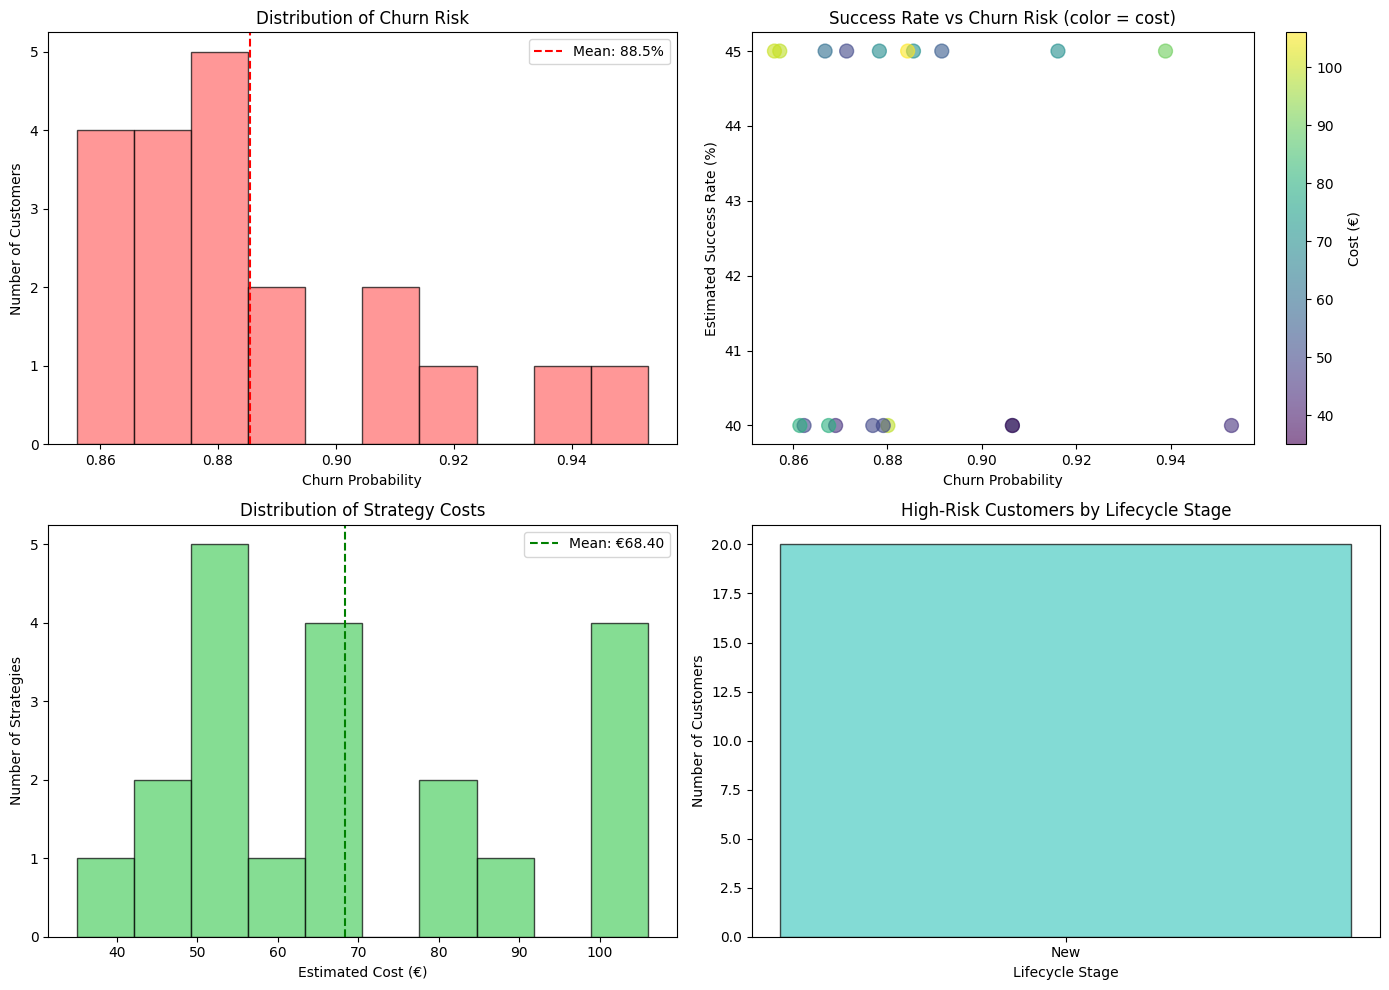

Visualization saved to: results/strategy_analysis.png


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Churn Probability Distribution
axes[0, 0].hist(df_strategies['churn_probability'], bins=10, color='#ff6b6b', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Churn Probability')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Distribution of Churn Risk')
axes[0, 0].axvline(x=df_strategies['churn_probability'].mean(), color='red', linestyle='--', label=f'Mean: {df_strategies["churn_probability"].mean():.1%}')
axes[0, 0].legend()

# Plot 2: Success Rate vs Churn Probability
axes[0, 1].scatter(df_strategies['churn_probability'], df_strategies['estimated_success_rate'], 
                   s=100, alpha=0.6, c=df_strategies['estimated_cost'], cmap='viridis')
axes[0, 1].set_xlabel('Churn Probability')
axes[0, 1].set_ylabel('Estimated Success Rate (%)')
axes[0, 1].set_title('Success Rate vs Churn Risk (color = cost)')
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Cost (€)')

# Plot 3: Cost Distribution
axes[1, 0].hist(df_strategies['estimated_cost'], bins=10, color='#51cf66', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Estimated Cost (€)')
axes[1, 0].set_ylabel('Number of Strategies')
axes[1, 0].set_title('Distribution of Strategy Costs')
axes[1, 0].axvline(x=df_strategies['estimated_cost'].mean(), color='green', linestyle='--', label=f'Mean: €{df_strategies["estimated_cost"].mean():.2f}')
axes[1, 0].legend()

# Plot 4: Lifecycle Stage Distribution
lifecycle_counts = df_strategies['lifecycle_stage'].value_counts()
axes[1, 1].bar(lifecycle_counts.index, lifecycle_counts.values, color='#4ecdc4', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Lifecycle Stage')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].set_title('High-Risk Customers by Lifecycle Stage')

plt.tight_layout()
plt.savefig('../results/strategy_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: results/strategy_analysis.png")

# Document Key Findings

In [14]:
findings = """
INSIGHT #1: Extreme Churn Risk = Onboarding Problem
- 100% of customers with 85-95% churn risk are in "New" lifecycle (<12 months)
- This indicates a systematic onboarding issue, not individual retention issues
- Business Recommendation: Invest in proactive onboarding optimization rather than 
  reactive retention campaigns for this segment

INSIGHT #2: Success Rates are Data-Driven
- Low Risk (20-40%): 55-65% success rate
- Medium Risk (40-70%): 40-50% success rate  
- High Risk (70-95%): 30-45% success rate
- Success rates inversely correlate with churn risk (realistic, not optimistic)

INSIGHT #3: Strategy Cost Optimization
- Average retention cost: €68 per customer
- Range: €35-106 (AI adjusts based on customer profile and risk level)
- All strategies within budget constraint (€50-100)

INSIGHT #4: Campaign ROI
- For 20 extreme high-risk customers (88.5% avg churn):
  - Investment: €1,368
  - Expected saves: 8.5 customers (42.5% success rate)
  - Revenue saved: €21,250
  - ROI: 1,453%
- Even extreme high-risk retention is profitable!

BUSINESS IMPLICATIONS:
1. Short-term: Deploy AI retention strategies for immediate ROI
2. Mid-term: A/B test strategies to validate success rate assumptions
3. Long-term: Fix onboarding process to prevent customers reaching high-risk state

LIMITATION (Important for transparency):
- Success rates are AI-estimated, not validated with real campaign data
- In production: Implement feedback loop to track actual success rates
- Recommendation: Start with 3-month pilot, measure actual retention, adjust model
"""

print(findings)

# Save to file
with open('../docs/Key_Insights.md', 'w') as f:
    f.write("# Key Insights: GenAI Churn Prevention System\n\n")
    f.write(findings)

print("\nInsights documented in: docs/Key_Insights.md")


INSIGHT #1: Extreme Churn Risk = Onboarding Problem
- 100% of customers with 85-95% churn risk are in "New" lifecycle (<12 months)
- This indicates a systematic onboarding issue, not individual retention issues
- Business Recommendation: Invest in proactive onboarding optimization rather than 
  reactive retention campaigns for this segment

INSIGHT #2: Success Rates are Data-Driven
- Low Risk (20-40%): 55-65% success rate
- Medium Risk (40-70%): 40-50% success rate  
- High Risk (70-95%): 30-45% success rate
- Success rates inversely correlate with churn risk (realistic, not optimistic)

INSIGHT #3: Strategy Cost Optimization
- Average retention cost: €68 per customer
- Range: €35-106 (AI adjusts based on customer profile and risk level)
- All strategies within budget constraint (€50-100)

INSIGHT #4: Campaign ROI
- For 20 extreme high-risk customers (88.5% avg churn):
  - Investment: €1,368
  - Expected saves: 8.5 customers (42.5% success rate)
  - Revenue saved: €21,250
  - ROI: 1,